In [1]:
import os
from pathlib import Path
import random

import pandas as pd
import numpy as np
from PIL import Image
import cv2

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import torchinfo


In [2]:
IS_KAGGLE=os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
PROJ_NAME='Digit Recognizer'
COMP_NAME='digit-recognizer'

if COMP_NAME is None:
    raise NameError("COMP_NAME has not been initialized")

RANDOM_SEED=42
BATCH_SIZE=100
DATA_PATH=Path(f'./{COMP_NAME}')
DEVICE='cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
print('kaggle: ', 'Y' if IS_KAGGLE else 'N' )
print(f"torch version: {torch.__version__}")
print(f'device: {DEVICE}')
print(f"{torch.cuda.device_count()} GPU(s) available")

kaggle:  N
torch version: 2.2.0
device: cpu
0 GPU(s) available


In [4]:
# Reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False


In [5]:
os.getcwd()

'/home/anushka/Documents/Deep  Learning Projects/Digit Recognizer'

## Load Data

In [6]:
train_data=pd.read_csv(DATA_PATH/'train.csv')
test_data=pd.read_csv(DATA_PATH/'test.csv')

In [7]:
print(f'train shape: {train_data.shape}')
print(f'test shape: {test_data.shape}')

train shape: (42000, 785)
test shape: (28000, 784)


In [8]:
X=train_data.iloc[:,train_data.columns!='label']
y=train_data['label'].values

print(f"X shape: {X.shape}\nX type: {type(X)}\n\n")
print(f"y shape: {y.shape}\ny type: {type(y)}")

X shape: (42000, 784)
X type: <class 'pandas.core.frame.DataFrame'>


y shape: (42000,)
y type: <class 'numpy.ndarray'>


## Data Exploration

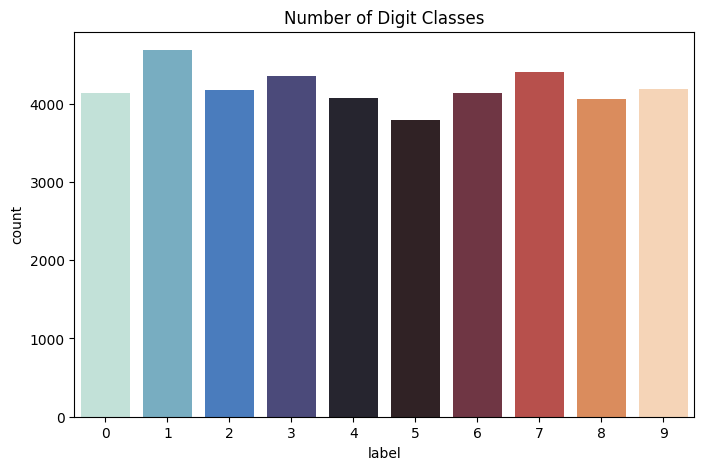

In [9]:
# visualize number of digit claases
plt.figure(figsize=(8,5))
g=sns.countplot(data=train_data,x='label',hue='label',palette='icefire',legend=False);
plt.title('Number of Digit Classes');


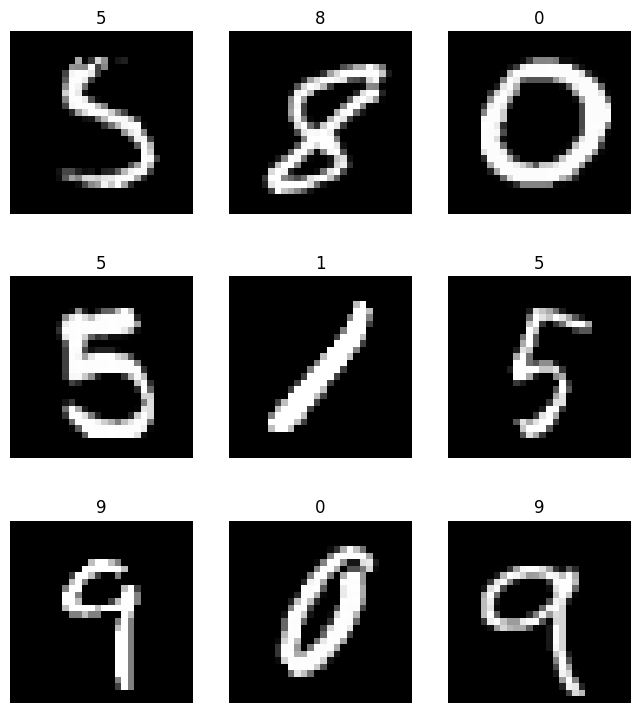

In [10]:
figure=plt.figure(figsize=(8,9))
cols,rows=3,3

for i in range(1,cols*rows+1):
    sample=random.randint(0,len(X)-1)
    label=str(int(y[sample]))
    img=X.values[sample].reshape(28,28) # Choose values of dataframe

    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img,cmap='gray')

plt.show()

In [11]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=RANDOM_SEED)

print(f"X_train:{X_train.shape}\ty_train:{y_train.shape}")
print(f"X_val:{X_val.shape}\ty_val:{y_val.shape}")

X_train:(33600, 784)	y_train:(33600,)
X_val:(8400, 784)	y_val:(8400,)


In [12]:
X_train

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
34941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38158,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Normalize [0,255] -> [0,1]
X_train=X_train.values/255.0
X_val=X_val.values/255.0

In [14]:
X_train_tensor=torch.from_numpy(X_train).type(dtype=torch.float32)
y_train_tensor=torch.from_numpy(y_train).type(dtype=torch.LongTensor)

X_val_tensor=torch.from_numpy(X_val).type(dtype=torch.float32)
y_val_tensor=torch.from_numpy(y_val).type(dtype=torch.LongTensor)

print(f"X_train_tensor dtype: {X_train_tensor.dtype}")
print(f"y_train_tensor dtype: {y_train_tensor.dtype}")

X_train_tensor dtype: torch.float32
y_train_tensor dtype: torch.int64


In [15]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset=TensorDataset(X_train_tensor,y_train_tensor)
val_dataset=TensorDataset(X_val_tensor,y_val_tensor)

train_loader=DataLoader(dataset=train_dataset,shuffle=True,batch_size=BATCH_SIZE)
val_loader=DataLoader(dataset=val_dataset,shuffle=False,batch_size=BATCH_SIZE)

## Build model

In [16]:
class DigitRecognizerModel(nn.Module):
    """
    Architecture Summary:
    Layer1: Convolution 1 > Activation (ReLU) > Pooling 1 > Dropout 1
    Layer2: Convolution 2 > Activation (ReLU) > Pooling 2 > Dropout 2 > Flatten
    Layer3: Linear 1 > Activation (ReLU) > Dropout 3
    Layer4: Linear 2 > Activation (ReLU) > Dropout 4
    Output: Linear 3 > Softmax
    """

    def __init__(self):
        super().__init__()

        # Layer 1
        self.conv1=nn.Conv2d(in_channels=1, out_channels=128,kernel_size=5, stride=1, padding=0)
        self.pool1=nn.MaxPool2d(kernel_size=(2,2))
        self.drop1=nn.Dropout(p=0.3)

        # Layer 2
        self.conv2=nn.Conv2d(in_channels=128,out_channels=224,kernel_size=5,stride=1,padding=0)
        self.pool2=nn.MaxPool2d(kernel_size=(2,2))
        self.drop2=nn.Dropout(p=0.4)

        # Layer 3
        self.linear1=nn.Linear(in_features=224*4*4,out_features=64)
        self.drop3=nn.Dropout(p=0.4)

        # Layer 4
        self.linear2=nn.Linear(in_features=64,out_features=32)
        self.drop4=nn.Dropout(p=0.4)
         
        # output
        self.linear3=nn.Linear(in_features=32,out_features=10)

    def forward(self,x):
        out=self.drop1(self.pool1(F.relu(self.conv1(x))))
        out=self.drop2(self.pool2(F.relu(self.conv2(out))))
        out=out.view(-1,224*4*4) # faltten layer 2 output since layer 3 is linear

        out=self.drop3(F.relu(self.linear1(out)))
        out=self.drop4(F.relu(self.linear2(out)))

        out=self.linear3(out)
        return out


In [17]:
model=DigitRecognizerModel().to(DEVICE)

loss_fn=nn.CrossEntropyLoss()
learning_rate=0.001
optimizer=optim.Adam(params=model.parameters(),lr=learning_rate)

print(model)

DigitRecognizerModel(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(128, 224, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.4, inplace=False)
  (linear1): Linear(in_features=3584, out_features=64, bias=True)
  (drop3): Dropout(p=0.4, inplace=False)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (drop4): Dropout(p=0.4, inplace=False)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)


In [18]:
from torchinfo import summary
summary(model,input_size=(100,1,28,28),col_names=('input_size', 'output_size', 'num_params', 'kernel_size'), verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
DigitRecognizerModel                     [100, 1, 28, 28]          [100, 10]                 --                        --
├─Conv2d: 1-1                            [100, 1, 28, 28]          [100, 128, 24, 24]        3,328                     [5, 5]
├─MaxPool2d: 1-2                         [100, 128, 24, 24]        [100, 128, 12, 12]        --                        [2, 2]
├─Dropout: 1-3                           [100, 128, 12, 12]        [100, 128, 12, 12]        --                        --
├─Conv2d: 1-4                            [100, 128, 12, 12]        [100, 224, 8, 8]          717,024                   [5, 5]
├─MaxPool2d: 1-5                         [100, 224, 8, 8]          [100, 224, 4, 4]          --                        [2, 2]
├─Dropout: 1-6                           [100, 224, 4, 4]          [100, 224, 4, 4]          --                        -

## Train Model

In [19]:
def train_loop(dataloader,model,loss_fn,optimizer,print_every=20):
    size=len(dataloader.dataset)
    model.train()

    for batch, (X,y) in enumerate(dataloader):
        X=X.view(-1,1,28,28).float().to(DEVICE)
        y=y.to(DEVICE)

        logits=model(X)
        loss=loss_fn(logits,y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch%print_every==0:
            loss,current=loss.item(),(batch+1)*len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


In [20]:
def val_loop(dataloader,model,loss_fn,print_every=100):
    size=len(dataloader.dataset)
    model.eval()
    batches=len(dataloader)
    loss,correct=0,0

    with torch.no_grad():
        for X,y in dataloader:
            X=(X.view(-1,1,28,28)).float().to(DEVICE)
            y=y.to(DEVICE)

            logits=model(X)
            loss+=loss_fn(logits,y).item()
            correct+=(logits.argmax(1)==y).sum().item()

    loss/=84
    correct/=size
    print(f"Validation Accuracy: {(100*correct):>0.1f}%, Average_Loss: {loss:>8f}\n")

In [21]:
# # # X_val.shape
# # next(iter(val_loader))[1]
# len(train_loader.dataset)/100

In [22]:
epochs=3

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n------------------------------------------")
    train_loop(train_loader,model,loss_fn,optimizer)
    val_loop(val_loader,model,loss_fn)

Epoch 1
------------------------------------------
loss: 2.306907  [  100/33600]
loss: 2.150813  [ 2100/33600]
loss: 1.602452  [ 4100/33600]
loss: 1.181918  [ 6100/33600]
loss: 1.080840  [ 8100/33600]
loss: 0.952589  [10100/33600]
loss: 0.653788  [12100/33600]
loss: 0.939428  [14100/33600]
loss: 0.489698  [16100/33600]
loss: 0.456344  [18100/33600]
loss: 0.628920  [20100/33600]
loss: 0.755805  [22100/33600]
loss: 0.560270  [24100/33600]
loss: 0.509677  [26100/33600]
loss: 0.587804  [28100/33600]
loss: 0.380352  [30100/33600]
loss: 0.383882  [32100/33600]
Validation Accuracy: 96.7%, Average_Loss: 0.118520

Epoch 2
------------------------------------------
loss: 0.290755  [  100/33600]
loss: 0.338503  [ 2100/33600]
loss: 0.151479  [ 4100/33600]
loss: 0.462632  [ 6100/33600]
loss: 0.414743  [ 8100/33600]
loss: 0.449820  [10100/33600]
loss: 0.558148  [12100/33600]
loss: 0.304096  [14100/33600]
loss: 0.585556  [16100/33600]
loss: 0.333509  [18100/33600]
loss: 0.211779  [20100/33600]
loss: 

## Prediction

In [23]:
from sklearn.metrics import confusion_matrix


In [24]:
model.eval()
with torch.no_grad():
    y_pred=model(X_val_tensor.view(-1,1,28,28))

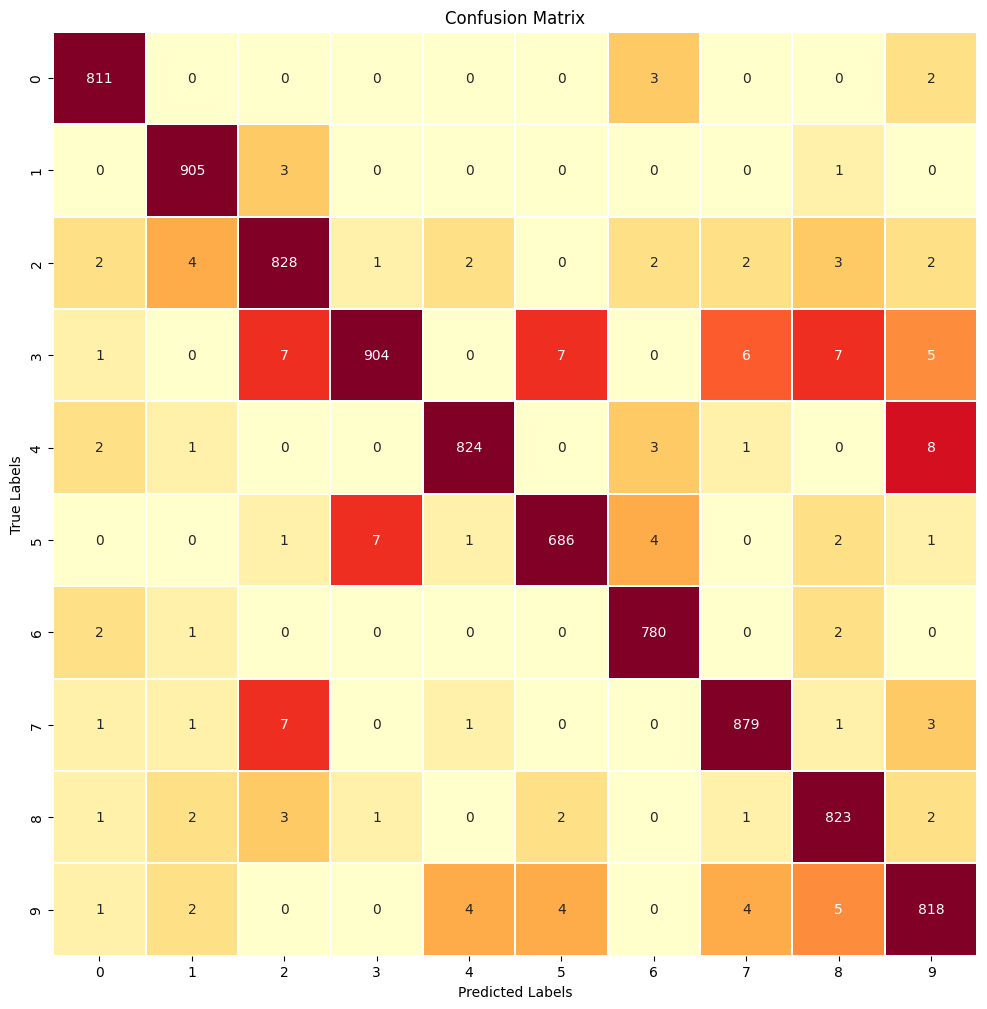

In [27]:
y_pred_classes=np.argmax(y_pred,axis=1)

conf_matrix=confusion_matrix(y_val_tensor,y_pred_classes)
# plot the confusion matrix
fig,ax=plt.subplots(figsize=(12,12))
sns.heatmap(conf_matrix,annot=True,cmap='YlOrRd',cbar=False,ax=ax,fmt='.0f',square=True,vmin=0,vmax=10,linewidth=0.05)
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
ax.set_title("Confusion Matrix")
plt.show()